# $\rho'$ analysis notes

### Data scheme

In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import pandas as ps
import awkward

ccup9_2015_my_test = r"D:\GoogleDrive\Job\cern\Alice\analysis\dev\grid\selection\RhoPrime\macro\AnalysisResults.root"
ccup9_2015_my = r'D:\GoogleDrive\Job\cern\Alice\analysis\data\RhoPrime\2015\RhoPrime2015o.root'
ccup9_2015_my_new = r'D:\GoogleDrive\Job\cern\Alice\analysis\data\RhoPrime\2015\4Prongs2015oPartNew.root'


events = uproot.open(ccup9_2015_my_new)['4Prongs/events']
events.show()
print(events.name, events.title, events.numentries)

# mycache = uproot.ArrayCache(1024*1024 * 10)
data = events.arrays('*', namedecode="utf-8")
# data = events.lazyarrays('*', namedecode="utf-8")

print(data['nTracks'].sum())

## I forgot to clear T_ITSsa vector before new tracks filling for event. This led to uncorrect data in the vector,
## but I have correct vectors for other track parameters, that means I know their sizes. It allows me
## to take last n elements from each vector T_ITSsa where n - is correct size from any other track vector for event

n=0
newT_ITSsa = []

for c in data['T_ITSRefit'].counts:
      newT_ITSsa.append(data['T_ITSsa'][n][-c:].tolist())
      n+=1

newT_ITSsa = awkward.fromiter(newT_ITSsa)

# test

assert True == ((newT_ITSsa.counts == data['T_ITSRefit'].counts) * (newT_ITSsa.counts == data['T_Phi'].counts)).all()
assert True == ((newT_ITSsa.starts == data['T_ITSRefit'].starts) * (newT_ITSsa.starts == data['T_Phi'].starts)).all()
assert True == ((newT_ITSsa.stops  == data['T_ITSRefit'].stops ) * (newT_ITSsa.stops  == data['T_Phi'].stops )).all()

RunNum                     (no streamer)              asdtype('>i4')
PeriodNumber               (no streamer)              asdtype('>u4')
OrbitNumber                (no streamer)              asdtype('>u4')
BunchCrossNumber           (no streamer)              asdtype('>u2')
Mass                       (no streamer)              asdtype('>f4')
Pt                         (no streamer)              asdtype('>f4')
Q                          (no streamer)              asdtype('>i2')
Rapidity                   (no streamer)              asdtype('>f4')
Phi                        (no streamer)              asdtype('>f4')
ZNAenergy                  (no streamer)              asdtype('>f4')
ZNCenergy                  (no streamer)              asdtype('>f4')
ZPAenergy                  (no streamer)              asdtype('>f4')
ZPCenergy                  (no streamer)              asdtype('>f4')
VtxX                       (no streamer)              asdtype('>f4')
VtxY                       (no str

### Run numbers from 2015o period

245145 243
245146 283
245151 31
245152 35
245231 63
245232 140
245259 102
245345 884
245346 154
245347 781
245349 868
245353 1943
245396 779
245397 900
245401 728
245407 2428
245409 1750
245410 585
245411 2042
245441 1028
245446 157
245450 320
245453 1297
245496 458
245501 1143
245504 766
245505 420
245507 2832
245540 383
245542 648
245543 1561
245544 124
245545 125
245554 2333
245692 895
245702 132
245705 412
245775 2245
245793 1419
245829 569
245831 953
245833 222
245923 41
245949 320
245952 1868
245954 1434
246001 942
246003 287
246012 566
246037 209
246042 653
246048 80
246049 944
246052 60
246087 2889
246089 142
246115 53
246151 571
246152 130
246153 1584
246178 176
246180 397
246181 615
246182 837
246185 101
246222 927
246225 543
246272 1107
246275 521
246276 324
246431 325
246434 760
246488 1260
246493 503
246495 181
246750 350
246751 317
246757 123
246758 437
246759 39
246760 471
246763 279
246765 171
246766 67
246805 508
246807 522
246809 998
246844 236
246845 354
246846 247
2

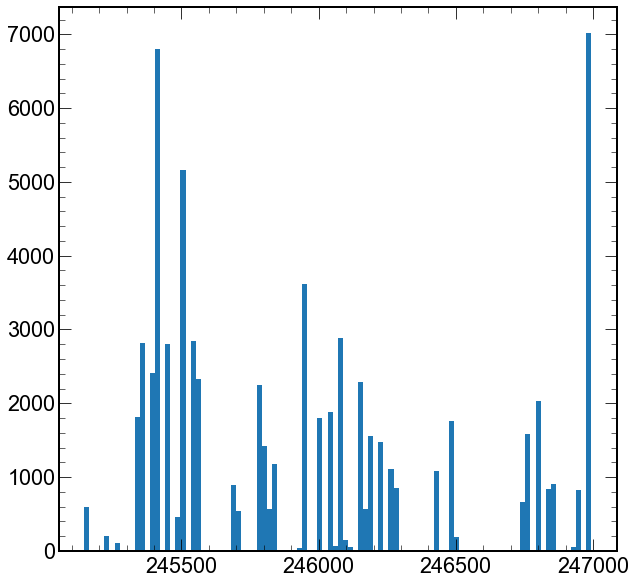

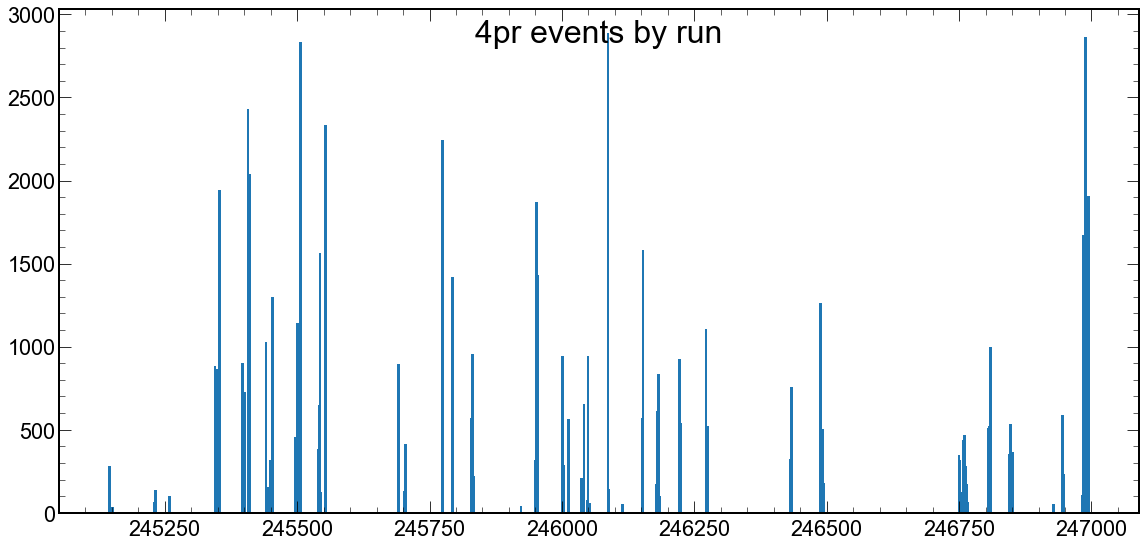

In [229]:
# print (np.unique(data['RunNum']))

runs = data['RunNum'][GoodEvents]

counts = plt.hist(runs,bins=len(np.unique(runs)))

bins = []
counts = []

for run in np.unique(runs):
    bins.append(run)
    counts.append((data['RunNum'][GoodEvents] == run).sum())
    print(run, (data['RunNum'][GoodEvents] == run).sum())

plt.style. use(hep.style.ROOT)
fig = plt.figure(figsize=(15, 7))
ax = fig.add_axes([0,0,1,1])
fig.suptitle('4pr events by run', fontsize=32)
ax.bar(bins,counts,width=5 )
# ax.set_xticks(bins)
# ax.set_xticklabels(bins,rotation=90, rotation_mode="anchor", ha="right")
plt.show()



## Selection criteria:

These criteria were applied on the selection stage:

Events:

    * Zero cumulative charge 
    * at least four tracks satisfy track selection criteria.
    
Tracks:

    * Has Point On inner or outer ITS Layer
    * dca1 < 2 and dca0 < (0.0182 + 0.0350 / TMath::Power(trk->Pt(), 1.01));

## Analysis criteria:

These criteria will apply for the selected data:

    * numbers of ITS clusters more then 3
    * not ITS SA


In [29]:
select    =  (data['T_ITSNCls'] > 3) * (~newT_ITSsa)

selectTpc = data['T_TPCRefit'] * (data['T_TPCNCls'] > 50) * (np.abs(data['T_NumberOfSigmaTPCPion']) < 3)

def GetGoodEvents(TrackNum=4, ChargeEqualCondition=True, charge=0, WithGoodNTpcTracks=0):
    
    GoodEvents = np.argwhere(select.sum()==TrackNum).flatten() # get events with 4 good tracks
    
    # add at least n tracks with tpc to selected
    GoodEvents = np.intersect1d(GoodEvents,np.argwhere(selectTpc.sum().flatten() >= WithGoodNTpcTracks).flatten())
    
    # get events that have total charge from 4 tracks 
    if ChargeEqualCondition:
        GoodEvents = GoodEvents[np.argwhere(data['T_Q'][GoodEvents.flatten()].sum()==charge).flatten()].flatten()  # get good events witch total charge zero
    else:
        GoodEvents = GoodEvents[np.argwhere(data['T_Q'][GoodEvents.flatten()].sum()!=charge).flatten()].flatten() # get good events witch total charge non zero
    return GoodEvents

## Data validation

### Duplicates

Cause of some reasons AliESD could contains the same track few times.

![img](https://sun9-69.userapi.com/c855620/v855620379/242fba/B1cMRF7RoH0.jpg)

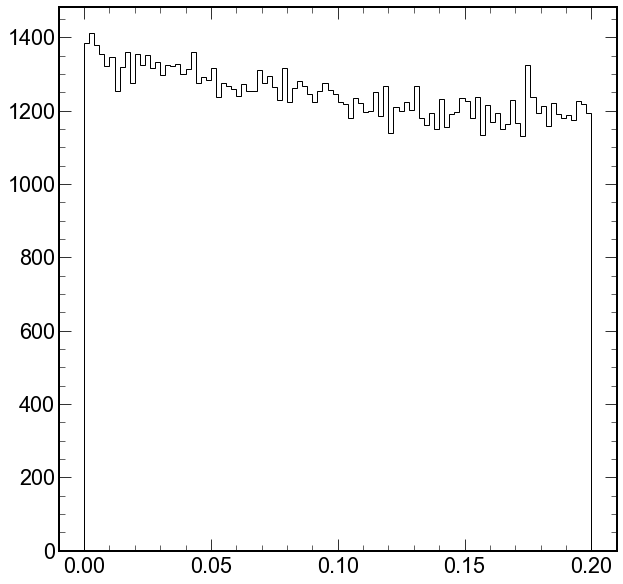

In [776]:
import math
differences = []
# GoodEvents = GetGoodEvents(TrackNum=4, WithGoodNTpcTracks=0)
# GoodEvents = GetUniqueGoodEvents()
entries = len(data['T_Px'][select])
ddpx = data['T_Px'][select]
ddpy = data['T_Py'][select]
ddpz = data['T_Pz'][select]
for event in range(entries):
    dpx = ddpx[event]
    dpy = ddpx[event]
    dpz = ddpx[event]
    N = len(dpx)
    for n in range(N):
        for j in range(n+1,N):
             
            differences.append(math.sqrt((dpx[n]-dpx[j])**2 + (dpy[n]-dpy[j])**2 + (dpz[n]-dpz[j])**2))

counts, bins = np.histogram(differences,bins=100, range=(0,0.2))
plt.style.use(hep.style.ROOT)
_ = plt.hist(differences, bins=bins, histtype='step', color='black')



## Show any parameter

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


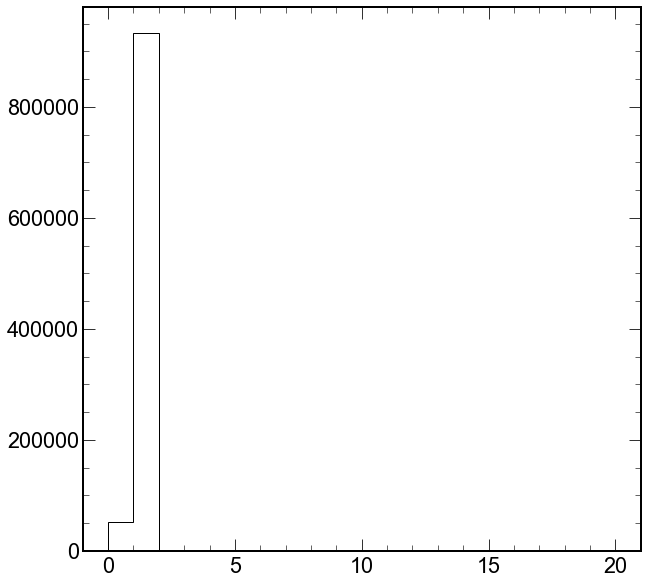

In [777]:
param = 'T_ITSRefit'
counts, bins = np.histogram(data[param].flatten(),bins=20, range=(0,20))
plt.style.use(hep.style.ROOT)
_= plt.hist(data[param].flatten(), bins=bins, histtype='step', color='black', label=f'Entries {np.sum(counts)}')


## Pt

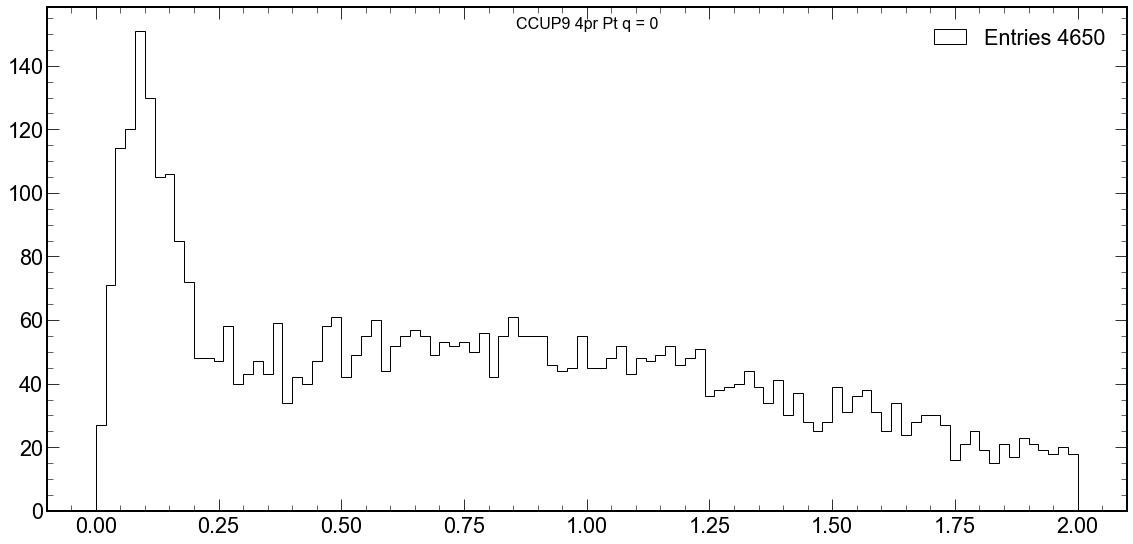

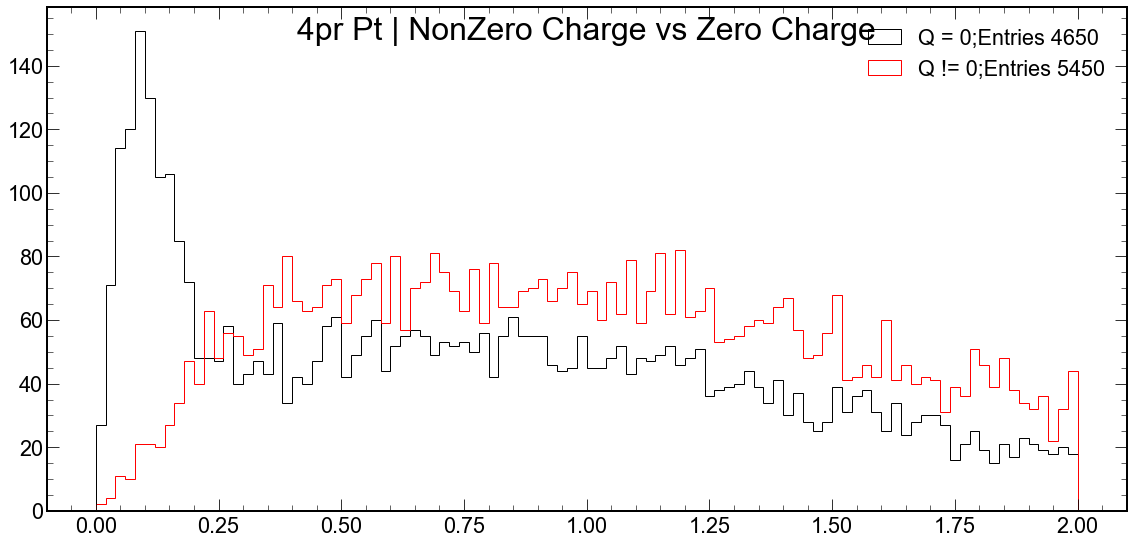

In [30]:
GoodEvents = GetGoodEvents(WithGoodNTpcTracks=0)
# GoodEvents = GetUniqueGoodEvents()
def GetPt(Draw=True, ChargeEqualCondition=True):
    pxg = data['T_Px'][GoodEvents]
    pyg = data['T_Py'][GoodEvents]

    pt = np.sqrt(pxg.sum()**2  + pyg.sum()**2)
    
    if Draw:
        counts, bins = np.histogram(pt,bins=100, range=(0,2))
        fig = plt.figure(figsize=(15, 7))
        ax = fig.add_axes([0,0,1,1])
        fig.suptitle('CCUP9 4pr Pt q = 0', fontsize=16)
        if ChargeEqualCondition:
            fig.suptitle('CCUP9 4pr Pt q = 0', fontsize=16)
        else:
            fig.suptitle('CCUP9 4pr Pt q != 0', fontsize=16)
            
        plt.style.use(hep.style.ROOT)
        ax.hist(pt, bins=bins, histtype='step', color='black', label=f'Entries {np.sum(counts)}')
        ax.legend()
    else:
        return pt
GetPt()


## Zero charge vs Non zero charge
fig = plt.figure(figsize=(15, 7))
ax = fig.add_axes([0,0,1,1])
fig.suptitle(f'4pr Pt | NonZero Charge vs Zero Charge', fontsize=32)
plt.style.use(hep.style.ROOT)
GoodEvents = GetGoodEvents(WithGoodNTpcTracks=0)
ptzq = GetPt(Draw=False)
counts, bins = np.histogram(ptzq, bins=100, range=(0,2))
_ = ax.hist(ptzq, bins=bins, color='black', histtype='step', label=f'Q = 0;Entries {np.sum(counts)}')
GoodEvents = GetGoodEvents(WithGoodNTpcTracks=0,ChargeEqualCondition=False)
ptnzq = GetPt(Draw=False,ChargeEqualCondition=False)
counts, bins = np.histogram(ptnzq, bins=100, range=(0,2))
_ = ax.hist(ptnzq, bins=bins, color='red', histtype='step', label=f'Q != 0;Entries {np.sum(counts)}')
ax.legend()

## Mass

<ipython-input-6-89cc099d0880>:15: RuntimeWarning: invalid value encountered in sqrt
  Mass = np.sqrt(Energy**2 - pxg.sum()**2 - pyg.sum()**2 - pzg.sum()**2)[(pt>ptMin)*(pt<=ptMax)]
C:\Python38\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Python38\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


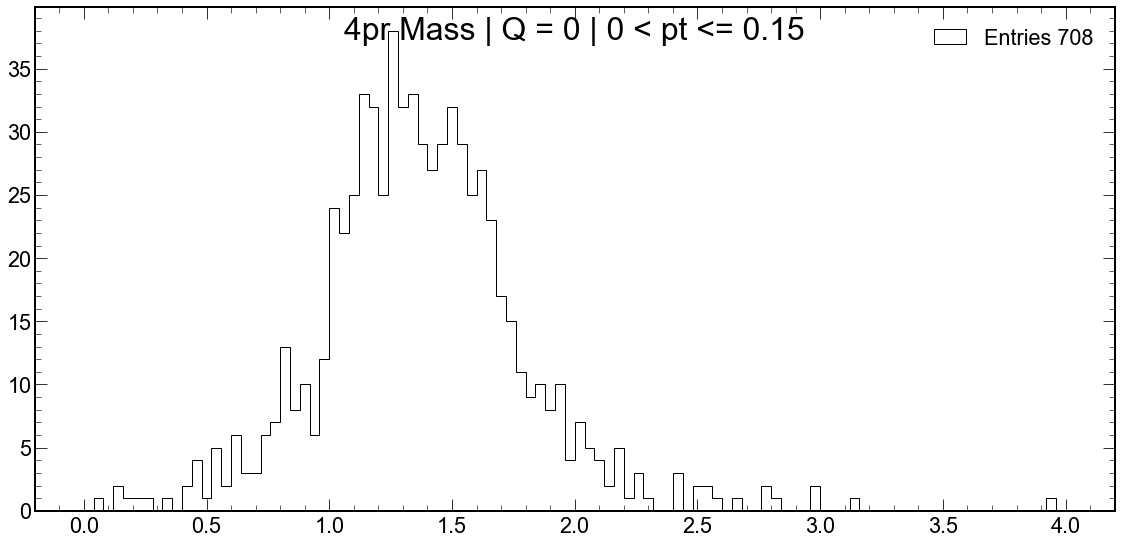

In [6]:
def GetMass(ptMin=0, ptMax=0.15, Draw=True, ChargeEqualCondition=True):
    pxg = data['T_Px'][GoodEvents]
    pyg = data['T_Py'][GoodEvents]
    pzg = data['T_Pz'][GoodEvents]
    massPion = np.full(pxg.shape[0], 0.140)
    pt = np.sqrt(pxg.sum()**2  + pyg.sum()**2)

    Energy0 = np.sqrt(massPion**2 + pxg[:,0]**2 + pyg[:,0]**2 + pzg[:,0]**2)
    Energy1 = np.sqrt(massPion**2 + pxg[:,1]**2 + pyg[:,1]**2 + pzg[:,1]**2)
    Energy2 = np.sqrt(massPion**2 + pxg[:,2]**2 + pyg[:,2]**2 + pzg[:,2]**2)
    Energy3 = np.sqrt(massPion**2 + pxg[:,3]**2 + pyg[:,3]**2 + pzg[:,3]**2)

    Energy = Energy0 + Energy1 + Energy2 + Energy3
    
    Mass = np.sqrt(Energy**2 - pxg.sum()**2 - pyg.sum()**2 - pzg.sum()**2)[(pt>ptMin)*(pt<=ptMax)]
    
    if Draw:
        fig = plt.figure(figsize=(15, 7))
        ax = fig.add_axes([0,0,1,1])
        if ChargeEqualCondition:
            fig.suptitle(f'4pr Mass | Q = 0 | {ptMin} < pt <= {ptMax}', fontsize=32)
        else:
            fig.suptitle(f'4pr Mass | Q != 0 | {ptMin} < pt <= {ptMax}', fontsize=32)
        plt.style.use(hep.style.ROOT)
        counts, bins = np.histogram(Mass, bins=100, range=(0,4))
        _ = ax.hist(Mass, bins=bins, color='black', histtype='step', label=f'Entries {np.sum(counts)}')
        ax.legend()
    else:
        return Mass
GoodEvents = GetGoodEvents()     
GetMass()

## Mass - pt - charge distirbution

<ipython-input-6-89cc099d0880>:15: RuntimeWarning: invalid value encountered in sqrt
  Mass = np.sqrt(Energy**2 - pxg.sum()**2 - pyg.sum()**2 - pzg.sum()**2)[(pt>ptMin)*(pt<=ptMax)]
C:\Python38\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Python38\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
<ipython-input-6-89cc099d0880>:15: RuntimeWarning: invalid value encountered in sqrt
  Mass = np.sqrt(Energy**2 - pxg.sum()**2 - pyg.sum()**2 - pzg.sum()**2)[(pt>ptMin)*(pt<=ptMax)]
C:\Python38\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Python38\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
<ipython-input-6-89cc099d0880>:15: RuntimeWarn

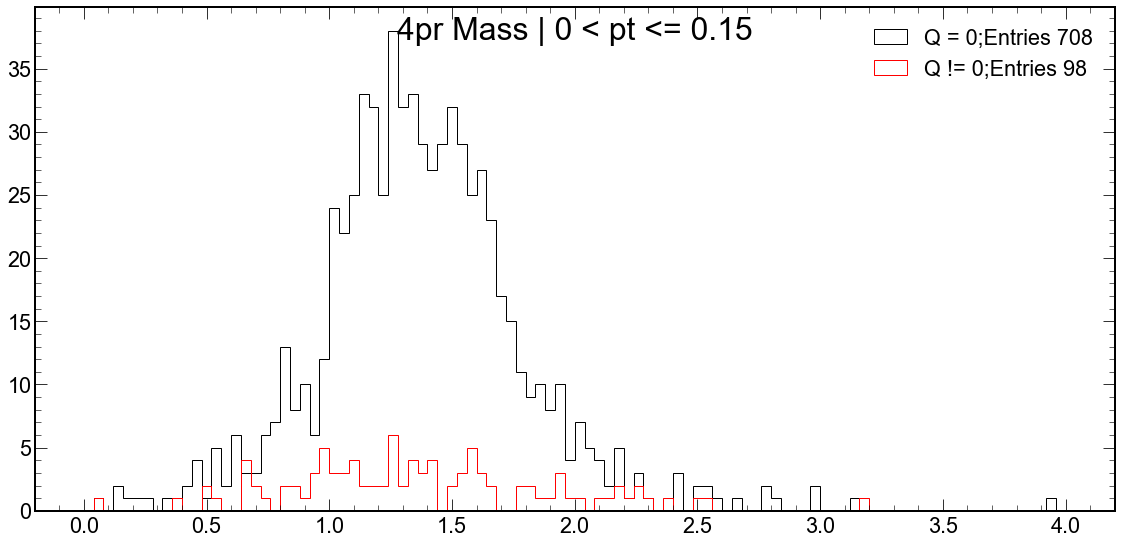

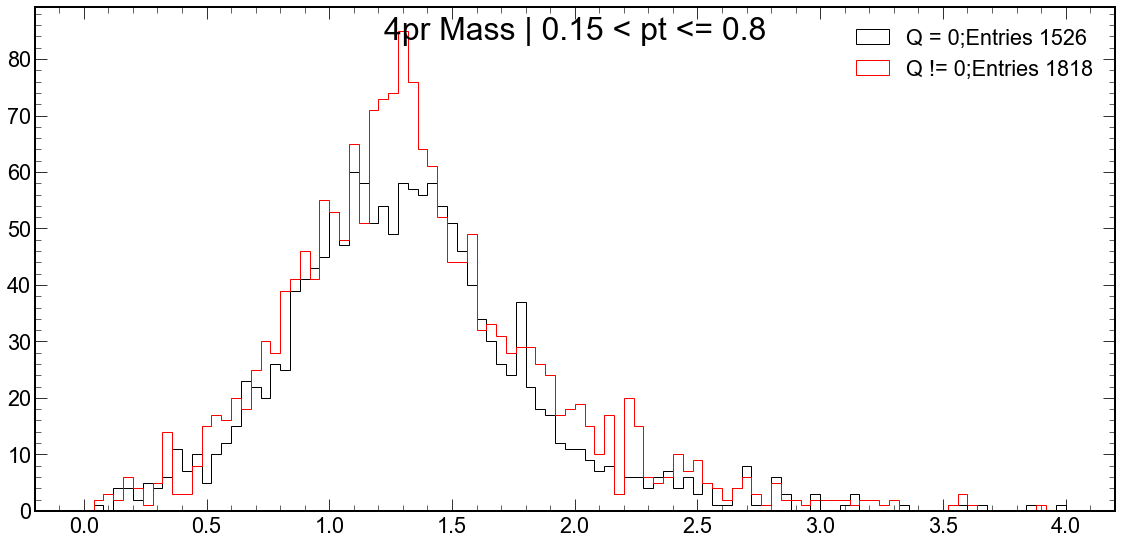

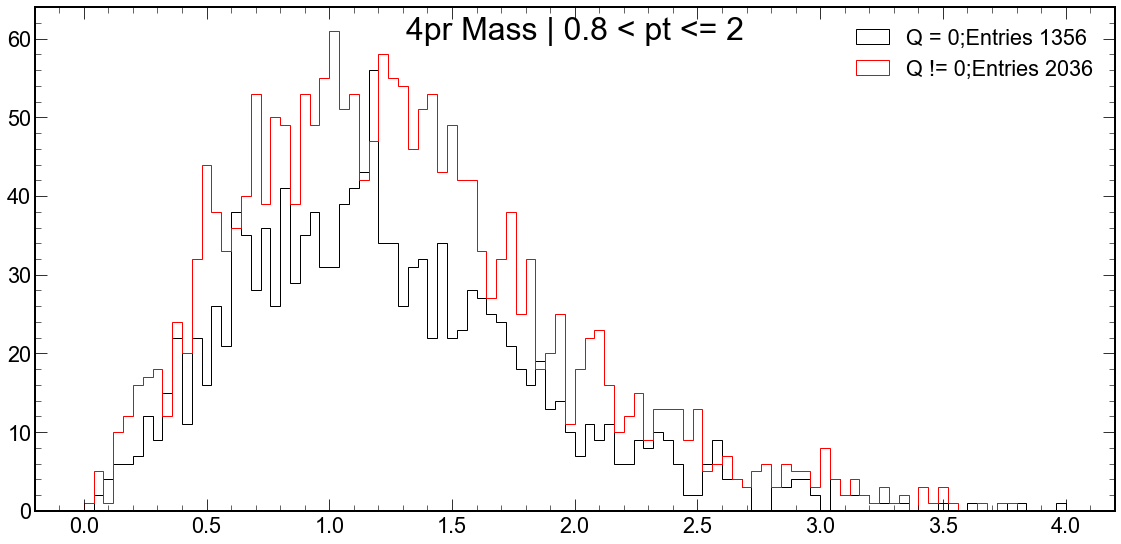

In [7]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_axes([0,0,1,1])
fig.suptitle(f'4pr Mass | {0} < pt <= {0.15}', fontsize=32)
plt.style.use(hep.style.ROOT)
GoodEvents = GetGoodEvents()
counts, bins = np.histogram(GetMass(Draw=False), bins=100, range=(0,4))
_ = ax.hist(GetMass(Draw=False), bins=bins, color='black', histtype='step', label=f'Q = 0;Entries {np.sum(counts)}')
GoodEvents = GetGoodEvents(ChargeEqualCondition=False)
counts, bins = np.histogram(GetMass(ChargeEqualCondition=False,Draw=False), bins=100, range=(0,4))
_ = ax.hist(GetMass(ChargeEqualCondition=False,Draw=False), bins=bins, color='red', histtype='step', label=f'Q != 0;Entries {np.sum(counts)}')
ax.legend()

fig = plt.figure(figsize=(15, 7))
ax = fig.add_axes([0,0,1,1])
fig.suptitle(f'4pr Mass | {0.15} < pt <= {0.8}', fontsize=32)
plt.style.use(hep.style.ROOT)
GoodEvents = GetGoodEvents()
counts, bins = np.histogram(GetMass(Draw=False, ptMin=0.15, ptMax=0.8), bins=100, range=(0,4))
_ = ax.hist(GetMass(Draw=False,ptMin=0.15, ptMax=0.8), bins=bins, color='black', histtype='step', label=f'Q = 0;Entries {np.sum(counts)}')
GoodEvents = GetGoodEvents(ChargeEqualCondition=False)
counts, bins = np.histogram(GetMass(ChargeEqualCondition=False,Draw=False,ptMin=0.15, ptMax=0.8), bins=100, range=(0,4))
_ = ax.hist(GetMass(ChargeEqualCondition=False,Draw=False,ptMin=0.15, ptMax=0.8), bins=bins, color='red', histtype='step', label=f'Q != 0;Entries {np.sum(counts)}')
ax.legend()

fig = plt.figure(figsize=(15, 7))
ax = fig.add_axes([0,0,1,1])
fig.suptitle(f'4pr Mass | {0.8} < pt <= {2}', fontsize=32)
plt.style.use(hep.style.ROOT)
GoodEvents = GetGoodEvents()
counts, bins = np.histogram(GetMass(Draw=False, ptMin=0.8, ptMax=2), bins=100, range=(0,4))
_ = ax.hist(GetMass(Draw=False,ptMin=0.8, ptMax=2), bins=bins, color='black', histtype='step', label=f'Q = 0;Entries {np.sum(counts)}')
GoodEvents = GetGoodEvents(ChargeEqualCondition=False)
counts, bins = np.histogram(GetMass(ChargeEqualCondition=False,Draw=False,ptMin=0.8, ptMax=2), bins=100, range=(0,4))
_ = ax.hist(GetMass(ChargeEqualCondition=False,Draw=False,ptMin=0.8, ptMax=2), bins=bins, color='red', histtype='step', label=f'Q != 0;Entries {np.sum(counts)}')
ax.legend()



## TPC influence


In [60]:
GoodEvents = np.argwhere(select.counts==4)
GoodEvents
# get events that have total charge from 4 tracks 
# GoodEvents = GoodEvents[np.argwhere(data['IsCUP9'][GoodEvents.flatten()]==True).flatten()].flatten()
# GoodEvents = GoodEvents[np.argwhere(data['T_Q'][GoodEvents.flatten()].sum()==0).flatten()].flatten()
#(data['T_Q'][GoodEvents.flatten()]==1).sum()
data['T_Q'][1]         
# pxg = data['T_Px'][GoodEvents][select[GoodEvents]]
# pyg = data['T_Py'][GoodEvents][select[GoodEvents]]
# pzg = data['T_Pz'][GoodEvents][select[GoodEvents]]
# massPion = np.full(pxg.shape[0], 0.140)
# pt = np.sqrt(pxg.sum()**2  + pyg.sum()**2)

# Energy0 = np.sqrt(massPion**2 + pxg[:,0]**2 + pyg[:,0]**2 + pzg[:,0]**2)
# Energy1 = np.sqrt(massPion**2 + pxg[:,1]**2 + pyg[:,1]**2 + pzg[:,1]**2)
# Energy2 = np.sqrt(massPion**2 + pxg[:,2]**2 + pyg[:,2]**2 + pzg[:,2]**2)
# Energy3 = np.sqrt(massPion**2 + pxg[:,3]**2 + pyg[:,3]**2 + pzg[:,3]**2)
# Energy = Energy0 + Energy1 + Energy2 + Energy3
    
# Mass = np.sqrt(Energy**2 - pxg.sum()**2 - pyg.sum()**2 - pzg.sum()**2)[(pt>ptMin)*(pt<=ptMax)]
    

# fig = plt.figure(figsize=(15, 7))
# ax = fig.add_axes([0,0,1,1])
# fig.suptitle(f'4pr Mass | Q != 0 | {ptMin} < pt <= {ptMax}', fontsize=32)
# plt.style.use(hep.style.ROOT)
# counts, bins = np.histogram(Mass, bins=100, range=(0,4))
# _ = ax.hist(Mass, bins=bins, color='black', histtype='step', label=f'Entries {np.sum(counts)}')
# ax.legend()

array([-1,  1, -1,  1], dtype=int16)

## Energy losses

* all tracks

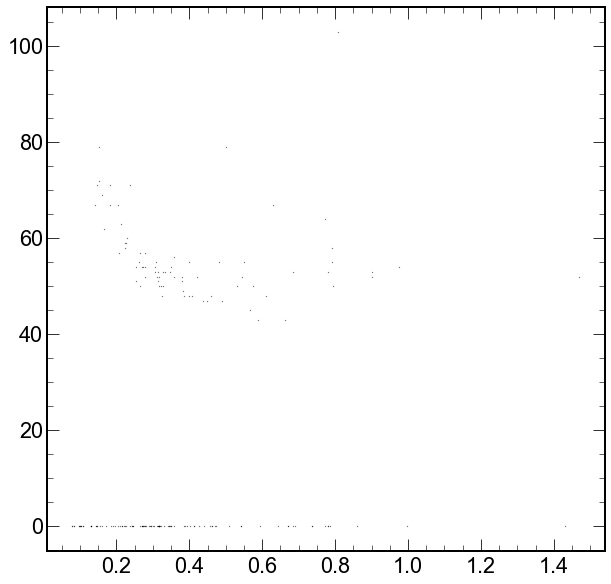

In [8]:
from scipy.stats import gaussian_kde

pt = np.sqrt(data['T_Px']**2 + data['T_Py']**2)#[(np.abs(data['T_NumberOfSigmaTPCPion']) < 3)]
dedx = data['TPCsignal'][(pt<2)].flatten()#[(np.abs(data['T_NumberOfSigmaTPCPion']) < 3)]
pt = pt[pt<2].flatten()
# z = gaussian_kde(pt)(dedx)

plt.style.use(hep.style.ROOT)
plt.scatter(pt.flatten(), dedx.flatten(),s=0.05, color='black')

* only selected events

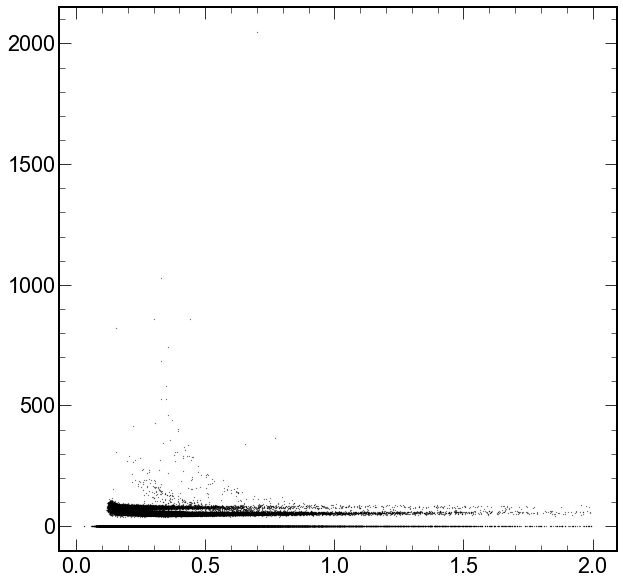

In [136]:
from scipy.stats import gaussian_kde

ptTracks = np.sqrt(pxg**2  + pyg**2).flatten()
dedx = data['TPCsignal'][GoodEvents].flatten()[ptTracks<2]
ptTracks = ptTracks[ptTracks<2]
# z = gaussian_kde(pt)(dedx)
plt.style.use(hep.style.ROOT)
plt.scatter(ptTracks.flatten(), dedx.flatten(),s=0.05, color = 'black')

In [793]:
import pandas as pd
# select    = ((data['T_HasPointOnITSLayer0']) + (data['T_HasPointOnITSLayer1'])) * \
#               data['T_ITSRefit']  * (np.abs(data['T_NumberOfSigmaITSPion']) < 3) * (data['T_ITSNCls'] >3) \
#               * data['T_TPCRefit']  * (data['T_TPCNCls'] > 50) * (np.abs(data['T_NumberOfSigmaTPCPion']) < 3) 

# good events with more than 4 tracks (108,  111, 1023, 1371, 2156, 2558, 2727, 2811, 3391, 3478)
print(GoodEvents[30:50])
# 15     
n = 3410
print('ITS_sa',newT_ITSsa[n], len(newT_ITSsa[n]))
events.pandas.df(["T_Q", "T_P*", "*Cls", "*Refit", "RunNum"], entrystart=n, entrystop=n+1)



[3410 3423 3431 3462 3605 3629 3672 3679 3682 3727 3743 3799 3825 3846
 3855 4157 4193 4203 4210 4408]
ITS_sa [False False False False  True  True  True  True] 8


T_Q       T_P     T_Phi      T_Px      T_Py      T_Pz  \
entry subentry                                                          
3410  0          -1  0.467000  3.410958 -0.402915 -0.111235 -0.208267   
      1           1  0.662846  4.727661  0.010041 -0.657424 -0.084016   
      2          -1  0.694383  2.282900 -0.365024  0.422877  0.412432   
      3           1  0.495016  0.880614  0.270132  0.327178 -0.254997   
      4           1  0.642347  4.728225  0.010090 -0.637101 -0.081302   
      5          -1  0.488659  3.411844 -0.421495 -0.116766 -0.217934   
      6          -1  0.703976  2.283173 -0.370046  0.428458  0.418416   
      7           1  0.476571  0.881248  0.259871  0.315156 -0.245487   

                T_TPCNCls  T_ITSNCls  T_TPCRefit  T_ITSRefit  RunNum  
entry subentry                                                        
3410  0               154          6        True        True  245540  
      1               137          6        True        True  245540  
      2               127          5        True        True  245540  
      3               122          5        True        True  245540  
      4                 0          6       False        True  245540  
      5                 0          6       False        True  245540  
      6                 0          5       False        True  245540  
      7                 0          5       False        True  245540

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


(array([4767136., 2812777.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 1 Patch objects>)

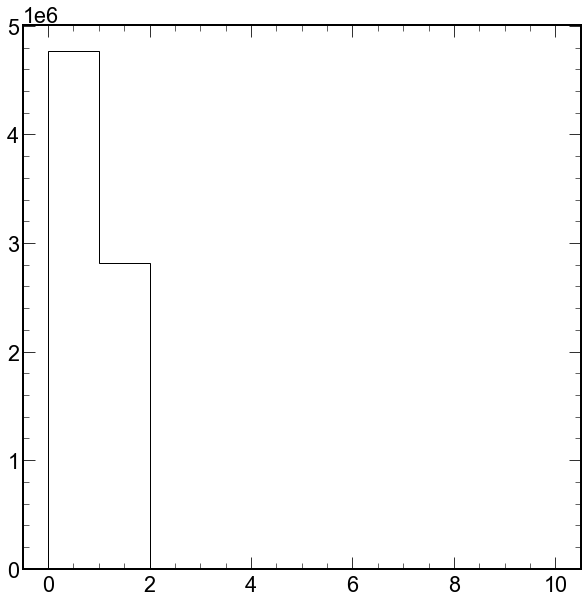

In [31]:
#data['T_Px'][GoodEvents]
a = np.array([[1,2,3,4], [1,1,2,3], [2,2,2,2], [5,6,7,7]])
px = awkward.fromiter([list(set(x)) for x in data['T_Px'][GoodEvents]])

In [138]:
select    =  data['T_ITSRefit']  * (np.abs(data['T_NumberOfSigmaITSPion']) < 3) * (data['T_ITSNCls'] >3) * data['IsCUP9'] \
            # * (data['T_TPCNCls'] < 50) #* (np.abs(data['T_NumberOfSigmaTPCPion']) < 3) # * data['T_TPCRefit'] 

selectTpc = data['T_TPCRefit'] * (data['T_TPCNCls'] > 50) * (np.abs(data['T_NumberOfSigmaTPCPion']) < 3)

GoodEvents = np.argwhere(select.sum()==4).flatten() # get events with 4 good tracks
#at leass n tracks with tpc
# n = 4
# EventsWithNTPC = np.argwhere(selectTpc.sum().flatten() >= n)
# GoodEvents = np.argwhere(select[np.argwhere(selectTpc[GoodEvents].sum().flatten() == n).flatten()].sum()==4).flatten()
# print(GoodEvents)
# GoodEvents = GoodEvents[(np.argwhere(select[GoodEvents].sum().flatten()==4)).flatten()]
    
# GoodEvents = GoodEvents[np.argwhere(data['T_Q'][GoodEvents.flatten()].sum()==0).flatten()].flatten()  # get good events witch total charge zero


In [727]:
np.argwhere(data['T_ITSRefit'].any()==False)

array([[    28],
       [    39],
       [    71],
       ...,
       [178242],
       [178294],
       [178308]], dtype=int64)